## Requirements

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import os
import math
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,make_scorer, precision_recall_curve, PrecisionRecallDisplay,confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, AveragePooling2D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l1, l2

2023-05-20 17:30:03.398543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Replicating DJTMNMO returns using MTUM and SPY returns

In [2]:
djm = pd.read_csv("Data.csv")

In [3]:
djm

,Effective date,Dow Jones U.S. Thematic Market Neutral Momentum Total Return Index,Dow Jones U.S. Thematic Market Neutral Momentum Index
0,30/04/10,957.32,NaN
1,01/05/10,957.32,NaN
2,02/05/10,957.32,NaN
3,03/05/10,972.82,NaN
4,04/05/10,959.97,NaN
...,...,...,...
2852,05/05/20,1363.20,1443.13
2853,06/05/20,1372.54,1452.91
2854,07/05/20,1373.43,1454.12
2855,08/05/20,1355.27,1435.21


In [4]:
djm['Effective date '][0]

'30/04/10'

In [5]:
djm['date'] = pd.to_datetime(djm['Effective date '], format='%d/%m/%y')

In [6]:
djm.rename(columns={'date':"Date"}, inplace = True)

In [7]:
djm.set_index("Date", inplace =True)

In [8]:
dates = djm.index[djm['Dow Jones U.S. Thematic Market Neutral Momentum Index'].notnull()]

In [9]:
dates

DatetimeIndex(['2012-09-21', '2012-09-22', '2012-09-23', '2012-09-24',
               '2012-09-25', '2012-09-26', '2012-09-27', '2012-09-28',
               '2012-09-29', '2012-09-30',
               ...
               '2020-04-28', '2020-04-29', '2020-04-30', '2020-05-01',
               '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07',
               '2020-05-08', '2020-05-11'],
              dtype='datetime64[ns]', name='Date', length=1982, freq=None)

In [10]:
dates[0]

Timestamp('2012-09-21 00:00:00')

In [11]:
dates[-1]

Timestamp('2020-05-11 00:00:00')

In [12]:
##AGFiQ - MOM ticker

In [13]:
mom = yf.download('MOM', start=dates[0], end=dates[-1])

[*********************100%***********************]  1 of 1 completed


In [14]:
mom

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-09-21,24.809999,24.809999,24.809999,24.809999,24.809999,500
2012-09-24,25.040001,25.040001,25.010000,25.010000,25.010000,200
2012-09-25,25.000000,25.240000,25.000000,25.240000,25.240000,8490
2012-09-26,25.410000,25.410000,25.240000,25.296000,25.296000,1700
2012-09-27,25.242701,25.242701,25.242701,25.242701,25.242701,0
...,...,...,...,...,...,...
2020-05-04,28.758900,28.799601,28.615801,28.639999,28.639999,2740
2020-05-05,28.668400,29.410000,28.632000,29.392700,29.392700,3411
2020-05-06,29.195900,29.195900,29.174999,29.174999,29.174999,626


In [15]:
djm.drop(['Effective date '], axis=1, inplace=True)

In [16]:
djm.head()

,Dow Jones U.S. Thematic Market Neutral Momentum Total Return Index,Dow Jones U.S. Thematic Market Neutral Momentum Index
Date,,
2010-04-30,957.32,NaN
2010-05-01,957.32,NaN
2010-05-02,957.32,NaN
2010-05-03,972.82,NaN
2010-05-04,959.97,NaN


In [17]:
df = djm.merge(mom, left_index=True, right_index=True, how='left')

In [18]:
df

,Dow Jones U.S. Thematic Market Neutral Momentum Total Return Index,Dow Jones U.S. Thematic Market Neutral Momentum Index,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,
2010-04-30,957.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-01,957.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-02,957.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-03,972.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-04,959.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-05-05,1363.20,1443.13,28.668400,29.410000,28.632000,29.392700,29.392700,3411.0
2020-05-06,1372.54,1452.91,29.195900,29.195900,29.174999,29.174999,29.174999,626.0
2020-05-07,1373.43,1454.12,29.200001,29.318501,28.783501,29.318501,29.318501,5460.0


In [19]:
df = df.loc[dates[0]:dates[-1]]

In [20]:
df.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Dow Jones U.S. Thematic Market Neutral Momentum Total Return Index'], axis=1, inplace=True)

/var/folders/x9/86sjrd415rz_4n_jdwxv29b40000gn/T/ipykernel_54584/2812633487.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Dow Jones U.S. Thematic Market Neutral Momentum Total Return Index'], axis=1, inplace=True)


In [21]:
df.isna().sum()

Dow Jones U.S. Thematic Market Neutral Momentum Index     0
Adj Close                                                63
dtype: int64

In [22]:
df.rename(columns={'Dow Jones U.S. Thematic Market Neutral Momentum Index': 'DJTMNMO', 'Adj Close': 'MOM'}, inplace=True)

/var/folders/x9/86sjrd415rz_4n_jdwxv29b40000gn/T/ipykernel_54584/2399912672.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Dow Jones U.S. Thematic Market Neutral Momentum Index': 'DJTMNMO', 'Adj Close': 'MOM'}, inplace=True)


In [23]:
df

,DJTMNMO,MOM
Date,,
2012-09-21,1056.43,24.809999
2012-09-22,1056.43,NaN
2012-09-23,1056.43,NaN
2012-09-24,1058.32,25.010000
2012-09-25,1074.14,25.240000
...,...,...
2020-05-05,1443.13,29.392700
2020-05-06,1452.91,29.174999
2020-05-07,1454.12,29.318501


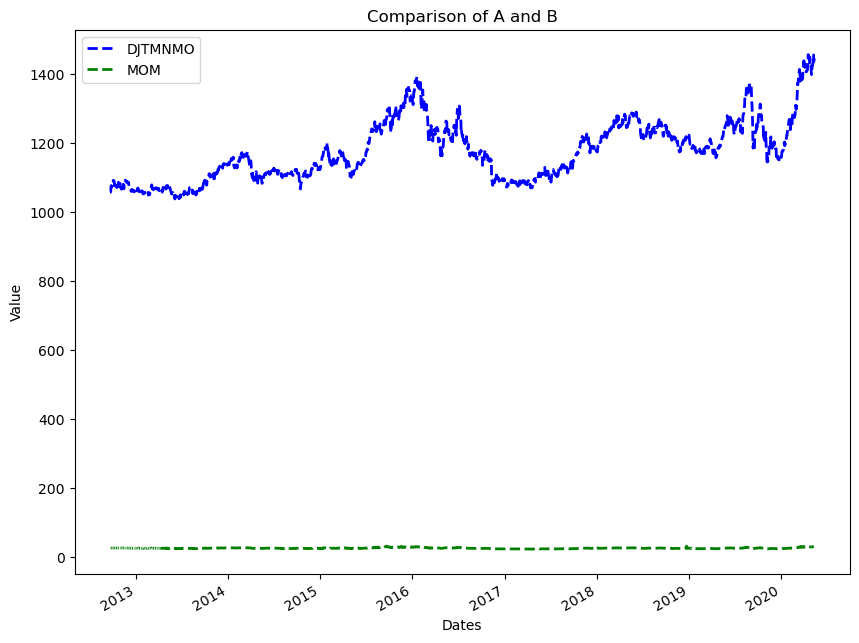

In [24]:
# Set the plot size and style
plt.style.use('default')

# Plot the two columns
ax = df.plot(y=['DJTMNMO', 'MOM'], use_index=True, linewidth=2, linestyle='--', color=['blue', 'green'], figsize=(10,8))

# Add axis labels and a title
ax.set_xlabel('Dates')
ax.set_ylabel('Value')
ax.set_title('Comparison of A and B')

# Add a legend
#ax.legend(['A', 'B'])

# Show the plot
plt.show()

In [25]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
copy_df = df.copy()

In [27]:
# Initialize the scaler object
scaler = MinMaxScaler()

# Fit and transform the data
copy_df[['DJTMNMO', 'MOM']] = scaler.fit_transform(copy_df[['DJTMNMO', 'MOM']])

copy_df

,DJTMNMO,MOM
Date,,
2012-09-21,0.046800,0.320422
2012-09-22,0.046800,NaN
2012-09-23,0.046800,NaN
2012-09-24,0.051317,0.343897
2012-09-25,0.089129,0.370892
...,...,...
2020-05-05,0.971079,0.858298
2020-05-06,0.994455,0.832746
2020-05-07,0.997347,0.849589


<AxesSubplot:xlabel='Date'>

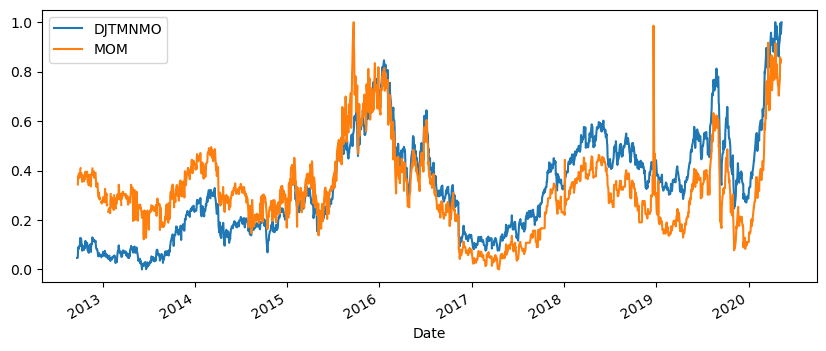

In [28]:
copy_df.plot(figsize=(10,4))

In [29]:
df

,DJTMNMO,MOM
Date,,
2012-09-21,1056.43,24.809999
2012-09-22,1056.43,NaN
2012-09-23,1056.43,NaN
2012-09-24,1058.32,25.010000
2012-09-25,1074.14,25.240000
...,...,...
2020-05-05,1443.13,29.392700
2020-05-06,1452.91,29.174999
2020-05-07,1454.12,29.318501


In [30]:
df['djm returns'] = df['DJTMNMO'].pct_change()

/var/folders/x9/86sjrd415rz_4n_jdwxv29b40000gn/T/ipykernel_54584/3838972650.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['djm returns'] = df['DJTMNMO'].pct_change()


In [31]:
df['mom returns'] = df['MOM'].pct_change()

/var/folders/x9/86sjrd415rz_4n_jdwxv29b40000gn/T/ipykernel_54584/1078271303.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mom returns'] = df['MOM'].pct_change()


<AxesSubplot:xlabel='Date'>

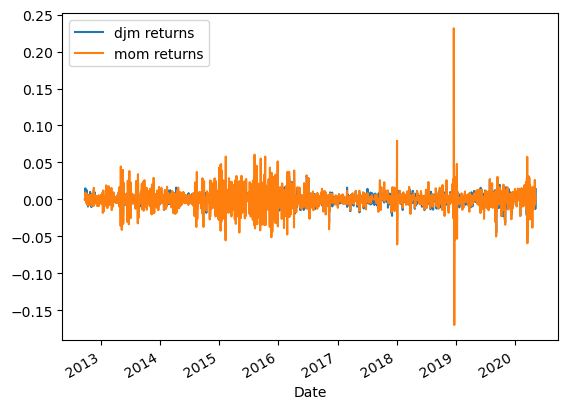

In [32]:
df[['djm returns','mom returns']].plot()

In [33]:
df['djm cum returns'] = (1+df['djm returns']).cumprod()
df['mom cum returns'] = (1+df['mom returns']).cumprod()

/var/folders/x9/86sjrd415rz_4n_jdwxv29b40000gn/T/ipykernel_54584/4253879337.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['djm cum returns'] = (1+df['djm returns']).cumprod()
/var/folders/x9/86sjrd415rz_4n_jdwxv29b40000gn/T/ipykernel_54584/4253879337.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mom cum returns'] = (1+df['mom returns']).cumprod()


<AxesSubplot:xlabel='Date'>

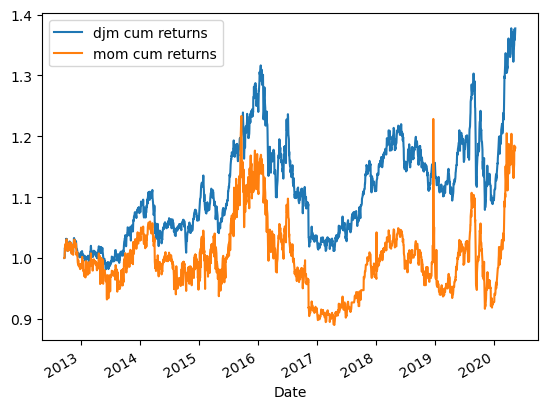

In [34]:
df[['djm cum returns','mom cum returns']].plot()

In [35]:
mtum = yf.download('MTUM', start=dates[0], end=dates[-1])
spy = yf.download('SPY', start=dates[0], end=dates[-1])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [36]:
mtum

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-04-18,50.919998,50.919998,50.919998,50.919998,44.848457,400
2013-04-19,50.919998,50.919998,50.919998,50.919998,44.848457,0
2013-04-22,50.919998,50.919998,50.919998,50.919998,44.848457,0
2013-04-23,52.220001,52.220001,52.220001,52.220001,45.993435,600
2013-04-24,51.700001,51.700001,51.560001,51.560001,45.412136,1100
...,...,...,...,...,...,...
2020-05-04,115.510002,117.639999,115.510002,117.589996,113.414459,861200
2020-05-05,118.680000,120.620003,118.510002,119.449997,115.208427,749700
2020-05-06,120.309998,120.739998,119.320000,119.419998,115.179489,544100


In [37]:
spy

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-09-21,146.639999,146.669998,145.809998,145.869995,119.839760,108737500
2012-09-24,145.149994,145.979996,145.039993,145.649994,119.659012,95682000
2012-09-25,145.960007,146.240005,144.059998,144.100006,118.385612,133165200
2012-09-26,144.070007,144.110001,142.949997,143.289993,117.720169,146502200
2012-09-27,143.889999,144.970001,143.509995,144.639999,118.829262,111830300
...,...,...,...,...,...,...
2020-05-04,280.739990,283.899994,279.130005,283.570007,270.879852,80873200
2020-05-05,286.640015,289.250000,283.709991,286.190002,273.382629,79569900
2020-05-06,288.040009,288.459991,283.779999,284.250000,271.529358,73632600


In [38]:
djm[djm['Dow Jones U.S. Thematic Market Neutral Momentum Index'].notnull()]

,Dow Jones U.S. Thematic Market Neutral Momentum Total Return Index,Dow Jones U.S. Thematic Market Neutral Momentum Index
Date,,
2012-09-21,1052.70,1056.43
2012-09-22,1052.70,1056.43
2012-09-23,1052.70,1056.43
2012-09-24,1054.60,1058.32
2012-09-25,1070.40,1074.14
...,...,...
2020-05-05,1363.20,1443.13
2020-05-06,1372.54,1452.91
2020-05-07,1373.43,1454.12


In [39]:
df2 = djm[djm['Dow Jones U.S. Thematic Market Neutral Momentum Index'].notnull()].merge(mtum['Adj Close'], left_index=True, right_index=True, how='left')

In [40]:
df2 = df2.merge(spy['Adj Close'],left_index=True, right_index=True, how='left')

In [41]:
df2

,Dow Jones U.S. Thematic Market Neutral Momentum Total Return Index,Dow Jones U.S. Thematic Market Neutral Momentum Index,Adj Close_x,Adj Close_y
Date,,,,
2012-09-21,1052.70,1056.43,NaN,119.839760
2012-09-22,1052.70,1056.43,NaN,NaN
2012-09-23,1052.70,1056.43,NaN,NaN
2012-09-24,1054.60,1058.32,NaN,119.659012
2012-09-25,1070.40,1074.14,NaN,118.385612
...,...,...,...,...
2020-05-05,1363.20,1443.13,115.208427,273.382629
2020-05-06,1372.54,1452.91,115.179489,271.529358
2020-05-07,1373.43,1454.12,116.008949,274.805908


In [42]:
df2.drop(['Dow Jones U.S. Thematic Market Neutral Momentum Total Return Index'], axis=1, inplace=True)

In [43]:
df2

,Dow Jones U.S. Thematic Market Neutral Momentum Index,Adj Close_x,Adj Close_y
Date,,,
2012-09-21,1056.43,NaN,119.839760
2012-09-22,1056.43,NaN,NaN
2012-09-23,1056.43,NaN,NaN
2012-09-24,1058.32,NaN,119.659012
2012-09-25,1074.14,NaN,118.385612
...,...,...,...
2020-05-05,1443.13,115.208427,273.382629
2020-05-06,1452.91,115.179489,271.529358
2020-05-07,1454.12,116.008949,274.805908


In [44]:
df2.columns

Index(['Dow Jones U.S. Thematic Market Neutral Momentum Index', 'Adj Close_x',
       'Adj Close_y'],
      dtype='object')

In [45]:
df2.rename(columns={'Dow Jones U.S. Thematic Market Neutral Momentum Index': 'DJTMNMO', 'Adj Close_x': 'MTUM', 
                   'Adj Close_y': 'SPY'}, inplace=True)

In [46]:
df2

,DJTMNMO,MTUM,SPY
Date,,,
2012-09-21,1056.43,NaN,119.839760
2012-09-22,1056.43,NaN,NaN
2012-09-23,1056.43,NaN,NaN
2012-09-24,1058.32,NaN,119.659012
2012-09-25,1074.14,NaN,118.385612
...,...,...,...
2020-05-05,1443.13,115.208427,273.382629
2020-05-06,1452.91,115.179489,271.529358
2020-05-07,1454.12,116.008949,274.805908


In [47]:
df2.isna().sum()

DJTMNMO      0
MTUM       204
SPY         63
dtype: int64

In [48]:
df2_notnull = df2.dropna()

In [49]:
df2_notnull

,DJTMNMO,MTUM,SPY
Date,,,
2013-04-18,1059.91,44.848457,128.099335
2013-04-19,1070.39,44.848457,129.213028
2013-04-22,1072.72,44.848457,129.786407
2013-04-23,1076.85,45.993435,131.124405
2013-04-24,1071.56,45.412136,131.207520
...,...,...,...
2020-05-04,1426.59,113.414459,270.879852
2020-05-05,1443.13,115.208427,273.382629
2020-05-06,1452.91,115.179489,271.529358


In [50]:
df2['Djm cum returns'] = (1+df2['DJTMNMO'].pct_change()).cumprod()
df2['Mtum cum returns'] = (1+df2['MTUM'].pct_change()).cumprod()
df2['Spy cum returns'] = (1+df2['SPY'].pct_change()).cumprod()

In [51]:
df2

,DJTMNMO,MTUM,SPY,Djm cum returns,Mtum cum returns,Spy cum returns
Date,,,,,,
2012-09-21,1056.43,NaN,119.839760,NaN,NaN,NaN
2012-09-22,1056.43,NaN,NaN,1.000000,NaN,1.000000
2012-09-23,1056.43,NaN,NaN,1.000000,NaN,1.000000
2012-09-24,1058.32,NaN,119.659012,1.001789,NaN,0.998492
2012-09-25,1074.14,NaN,118.385612,1.016764,NaN,0.987866
...,...,...,...,...,...,...
2020-05-05,1443.13,115.208427,273.382629,1.366044,2.568838,2.281235
2020-05-06,1452.91,115.179489,271.529358,1.375302,2.568193,2.265770
2020-05-07,1454.12,116.008949,274.805908,1.376447,2.586688,2.293111


<AxesSubplot:xlabel='Date'>

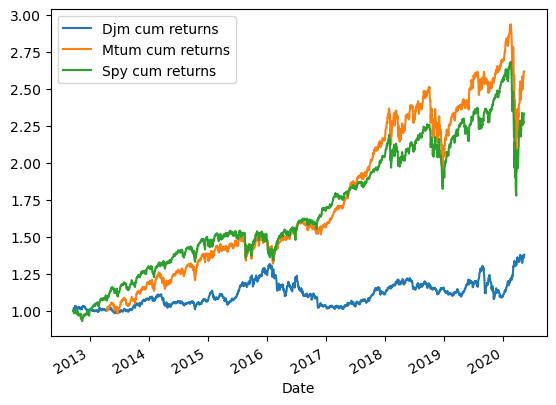

In [52]:
df2[['Djm cum returns', 'Mtum cum returns', 'Spy cum returns']].plot()

In [53]:
df2_notnull

,DJTMNMO,MTUM,SPY
Date,,,
2013-04-18,1059.91,44.848457,128.099335
2013-04-19,1070.39,44.848457,129.213028
2013-04-22,1072.72,44.848457,129.786407
2013-04-23,1076.85,45.993435,131.124405
2013-04-24,1071.56,45.412136,131.207520
...,...,...,...
2020-05-04,1426.59,113.414459,270.879852
2020-05-05,1443.13,115.208427,273.382629
2020-05-06,1452.91,115.179489,271.529358


In [54]:
mtum_returns= df2_notnull['MTUM'].pct_change()
spy_returns= df2_notnull['SPY'].pct_change()
djtmnmo_returns= df2_notnull['DJTMNMO'].pct_change()

In [55]:
mtum_returns = mtum_returns[1:]
spy_returns = spy_returns[1:]
djtmnmo_returns = djtmnmo_returns[1:]

In [56]:
import statsmodels.api as sm

# Regress DJTMNMO returns on MTUM and SPY returns
X = sm.add_constant(pd.concat([mtum_returns, spy_returns], axis=1))
y = djtmnmo_returns
results = sm.OLS(y, X).fit()

# Extract the regression coefficients (weights) and intercept
w_mtum, w_spy = results.params[1], results.params[2]
intercept = results.params[0]

# Calculate the daily returns for DJTMNMO using the regression coefficients
djtmnmo_returns_repl = w_mtum * mtum_returns + w_spy * spy_returns + intercept

In [57]:
returns_df = pd.concat([djtmnmo_returns, djtmnmo_returns_repl], axis=1)

In [58]:
returns_df.rename(columns={0: 'Replicated'}, inplace=True)

<AxesSubplot:xlabel='Date'>

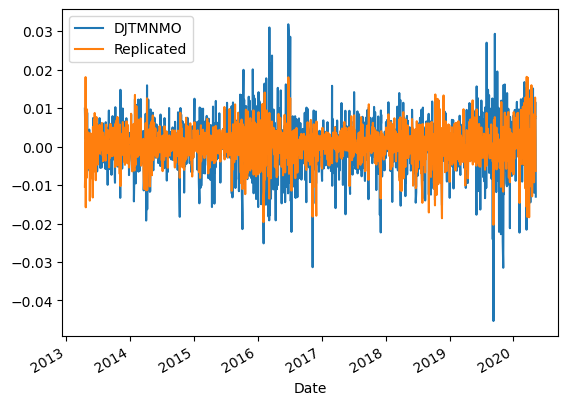

In [59]:
returns_df.plot()

In [60]:
returns_df

,DJTMNMO,Replicated
Date,,
2013-04-19,0.009888,-0.010400
2013-04-22,0.002177,-0.005276
2013-04-23,0.003850,0.018092
2013-04-24,-0.004912,-0.015766
2013-04-25,0.000784,0.000966
...,...,...
2020-05-04,0.007180,0.012774
2020-05-05,0.011594,0.007801
2020-05-06,0.006777,0.007926


In [61]:
returns_df['djm cum returns'] = (1+returns_df['DJTMNMO']).cumprod()
returns_df['replicated cum returns'] = (1+returns_df['Replicated']).cumprod()

<AxesSubplot:xlabel='Date'>

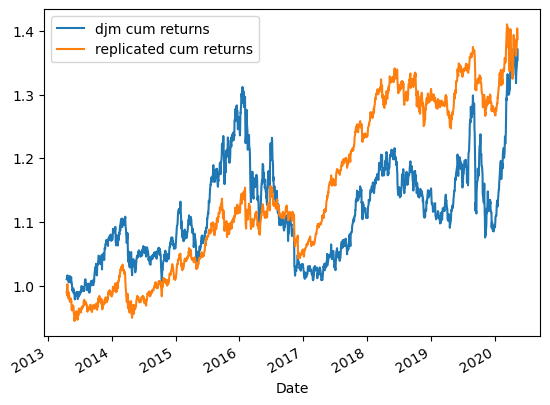

In [62]:
returns_df[['djm cum returns', 'replicated cum returns']].plot()

## Replicating using price instead of returns

In [63]:
df2_notnull

,DJTMNMO,MTUM,SPY
Date,,,
2013-04-18,1059.91,44.848457,128.099335
2013-04-19,1070.39,44.848457,129.213028
2013-04-22,1072.72,44.848457,129.786407
2013-04-23,1076.85,45.993435,131.124405
2013-04-24,1071.56,45.412136,131.207520
...,...,...,...
2020-05-04,1426.59,113.414459,270.879852
2020-05-05,1443.13,115.208427,273.382629
2020-05-06,1452.91,115.179489,271.529358


In [64]:
mtum_prices = df2_notnull['MTUM']
spy_prices = df2_notnull['SPY']
djtmnmo_prices = df2_notnull['DJTMNMO']

In [65]:
X = sm.add_constant(pd.concat([mtum_prices, spy_prices], axis=1))
y = djtmnmo_prices
results = sm.OLS(y, X).fit()

# Extract the regression coefficients (weights) and intercept
w_mtum, w_spy = results.params[1], results.params[2]
intercept = results.params[0]

# Calculate the daily returns for DJTMNMO using the regression coefficients
djtmnmo_prices_repl = w_mtum * mtum_prices + w_spy * spy_prices + intercept

In [66]:
prices_df = pd.concat([djtmnmo_prices, djtmnmo_prices_repl], axis=1)

In [67]:
prices_df.rename(columns={0: 'Replicated prices'}, inplace=True)

<AxesSubplot:xlabel='Date'>

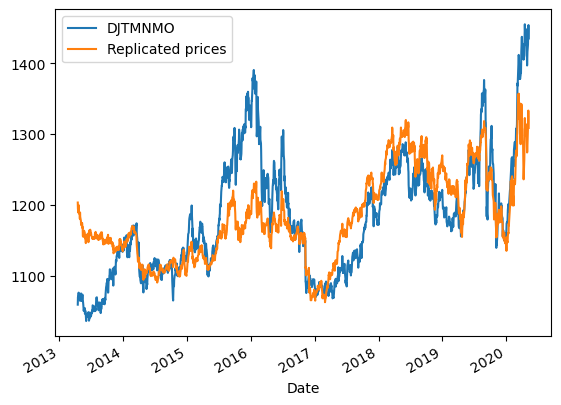

In [68]:
prices_df.plot()

In [69]:
print("Weight of SPY : ", w_spy)
print("Weight of MTUM : ", w_mtum)

Weight of SPY :  -8.275908300857372
Weight of MTUM :  18.72158657117157


## Quantitative Strategy - Momentum Crashes

In [70]:
df_WML = []
df_WML = prices_df[['Replicated prices']].copy()
df_WML['SPY prices'] = df2_notnull[['SPY']].copy()
df_WML['Replicated returns'] = df_WML['Replicated prices'].pct_change()
df_WML['SPY returns'] = df_WML['SPY prices'].pct_change()
#df_WML.dropna(inplace= True)
df_WML

,Replicated prices,SPY prices,Replicated returns,SPY returns
Date,,,,
2013-04-18,1203.884779,128.099335,NaN,NaN
2013-04-19,1194.667956,129.213028,-0.007656,0.008694
2013-04-22,1189.922719,129.786407,-0.003972,0.004437
2013-04-23,1200.285372,131.124405,0.008709,0.010309
2013-04-24,1188.714687,131.207520,-0.009640,0.000634
...,...,...,...,...
2020-05-04,1305.910648,270.879852,0.017137,0.002758
2020-05-05,1318.783826,273.382629,0.009858,0.009239
2020-05-06,1333.579560,271.529358,0.011219,-0.006779


In [71]:
df_WML_monthly = df_WML.groupby(pd.Grouper(freq='M')).sum()
df_WML_monthly['Replicated cum returns'] = (1+df_WML_monthly['Replicated returns']).cumprod()
df_WML_monthly['SPY cum returns'] = (1+df_WML_monthly['SPY returns']).cumprod()
df_WML_monthly

,Replicated prices,SPY prices,Replicated returns,SPY returns,Replicated cum returns,SPY cum returns
Date,,,,,,
2013-04-30,10723.922271,1177.767853,-0.019094,0.035446,0.980906,1.035446
2013-05-31,25697.638901,3001.924744,-0.019752,0.023812,0.961532,1.060102
2013-06-30,23116.812808,2699.428299,0.007020,-0.012290,0.968281,1.047073
2013-07-31,25441.474880,3065.154541,-0.005557,0.050649,0.962900,1.100106
2013-08-31,25427.446293,3073.350250,0.002543,-0.029979,0.965349,1.067126
...,...,...,...,...,...,...
2020-01-31,24852.768326,6520.841949,0.072346,0.000186,1.024114,2.411003
2020-02-29,23437.494513,5906.987976,0.026427,-0.080032,1.051178,2.218045
2020-03-31,29089.639882,5543.226593,0.033056,-0.099209,1.085925,1.997996


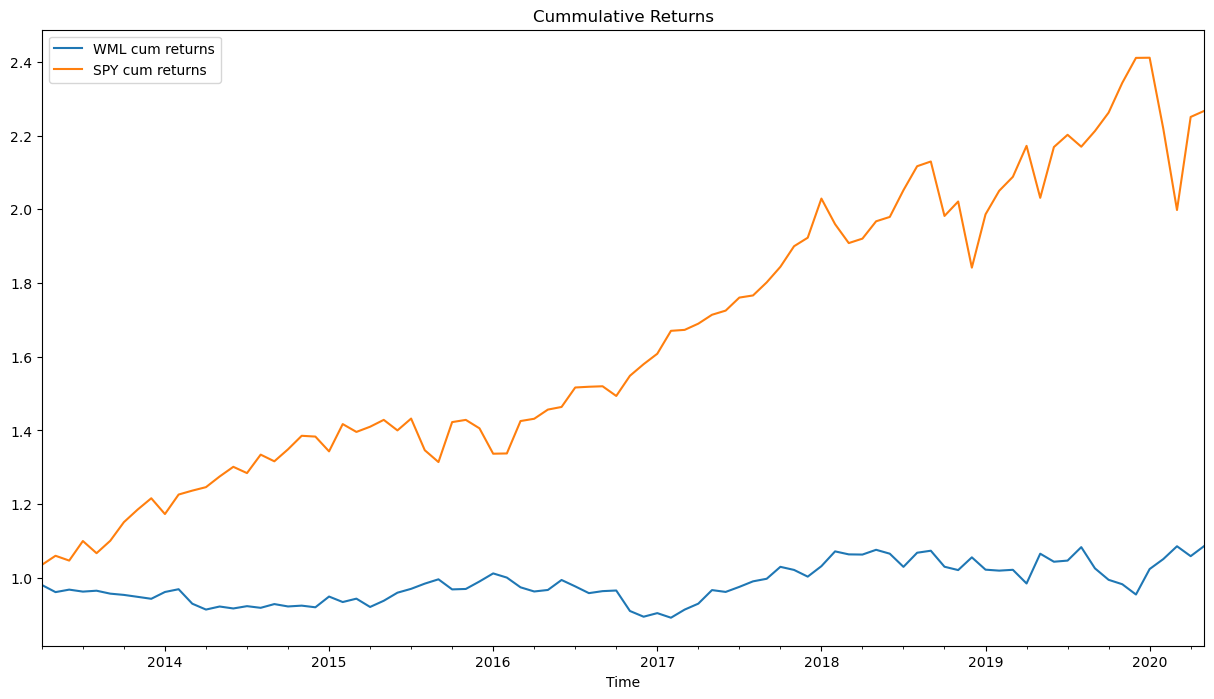

In [72]:
plt.figure(figsize=(15, 8))
df_WML_monthly['Replicated cum returns'].plot(label = 'WML cum returns')
df_WML_monthly['SPY cum returns'].plot(label = 'SPY cum returns')
plt.title('Cummulative Returns')
plt.xlabel('Time')
plt.legend()

In [73]:
series = df_WML_monthly['SPY returns']

# Calculate the cumulative sum using a rolling window of size 11
window_size = 12
df_WML_monthly['12 mn cumulative_SPY_returns'] = series.rolling(window=window_size).sum()
df_WML_monthly.dropna(inplace=True)
df_WML_monthly

,Replicated prices,SPY prices,Replicated returns,SPY returns,Replicated cum returns,SPY cum returns,12 mn cumulative_SPY_returns
Date,,,,,,,
2014-03-31,24176.826753,3311.677231,-0.040546,0.008665,0.930100,1.236817,0.219140
2014-04-30,23337.739764,3317.028641,-0.017087,0.007603,0.914208,1.246221,0.191297
2014-05-31,23257.254284,3368.083954,0.009051,0.023211,0.922482,1.275148,0.190697
2014-06-30,23199.613877,3476.018982,-0.005737,0.020571,0.917190,1.301379,0.223558
2014-07-31,24188.836443,3695.310211,0.006813,-0.013078,0.923439,1.284359,0.159831
...,...,...,...,...,...,...,...
2020-01-31,24852.768326,6520.841949,0.072346,0.000186,1.024114,2.411003,0.201402
2020-02-29,23437.494513,5906.987976,0.026427,-0.080032,1.051178,2.218045,0.089207
2020-03-31,29089.639882,5543.226593,0.033056,-0.099209,1.085925,1.997996,-0.028499


In [74]:
series = df_WML_monthly['12 mn cumulative_SPY_returns']
df_WML_monthly['Bull mkt ind'] = series.apply(lambda x: 1 if x < 0 else 0)
df_WML_monthly

,Replicated prices,SPY prices,Replicated returns,SPY returns,Replicated cum returns,SPY cum returns,12 mn cumulative_SPY_returns,Bull mkt ind
Date,,,,,,,,
2014-03-31,24176.826753,3311.677231,-0.040546,0.008665,0.930100,1.236817,0.219140,0
2014-04-30,23337.739764,3317.028641,-0.017087,0.007603,0.914208,1.246221,0.191297,0
2014-05-31,23257.254284,3368.083954,0.009051,0.023211,0.922482,1.275148,0.190697,0
2014-06-30,23199.613877,3476.018982,-0.005737,0.020571,0.917190,1.301379,0.223558,0
2014-07-31,24188.836443,3695.310211,0.006813,-0.013078,0.923439,1.284359,0.159831,0
...,...,...,...,...,...,...,...,...
2020-01-31,24852.768326,6520.841949,0.072346,0.000186,1.024114,2.411003,0.201402,0
2020-02-29,23437.494513,5906.987976,0.026427,-0.080032,1.051178,2.218045,0.089207,0
2020-03-31,29089.639882,5543.226593,0.033056,-0.099209,1.085925,1.997996,-0.028499,1


In [75]:
dates = df_WML_monthly.index[df_WML_monthly['Replicated prices'].notnull()]
risk_free_rate = yf.download("^TNX", start=dates[0], end=dates[-1])
risk_free_rate = risk_free_rate[['Close']].copy()
risk_free_rate['Close'] = risk_free_rate['Close']/100
risk_free_rate

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2014-03-31,0.02723
2014-04-01,0.02759
2014-04-02,0.02803
2014-04-03,0.02790
2014-04-04,0.02726
...,...
2020-05-22,0.00657
2020-05-26,0.00698
2020-05-27,0.00680


In [76]:
df_WML_monthly = df_WML_monthly.merge(risk_free_rate['Close'],left_index=True, right_index=True, how='left')
df_WML_monthly.rename(columns={'Close': 'rf Close'}, inplace=True)
df_WML_monthly['rf Close'] = df_WML_monthly['rf Close'].fillna((df_WML_monthly['rf Close'].shift() + df_WML_monthly['rf Close'].shift(-1)) / 2)
#df_WML_monthly.dropna(inplace = True)
df_WML_monthly

,Replicated prices,SPY prices,Replicated returns,SPY returns,Replicated cum returns,SPY cum returns,12 mn cumulative_SPY_returns,Bull mkt ind,rf Close
Date,,,,,,,,,
2014-03-31,24176.826753,3311.677231,-0.040546,0.008665,0.930100,1.236817,0.219140,0,0.02723
2014-04-30,23337.739764,3317.028641,-0.017087,0.007603,0.914208,1.246221,0.191297,0,0.02648
2014-05-31,23257.254284,3368.083954,0.009051,0.023211,0.922482,1.275148,0.190697,0,0.02582
2014-06-30,23199.613877,3476.018982,-0.005737,0.020571,0.917190,1.301379,0.223558,0,0.02516
2014-07-31,24188.836443,3695.310211,0.006813,-0.013078,0.923439,1.284359,0.159831,0,0.02556
...,...,...,...,...,...,...,...,...,...
2020-01-31,24852.768326,6520.841949,0.072346,0.000186,1.024114,2.411003,0.201402,0,0.01520
2020-02-29,23437.494513,5906.987976,0.026427,-0.080032,1.051178,2.218045,0.089207,0,0.01109
2020-03-31,29089.639882,5543.226593,0.033056,-0.099209,1.085925,1.997996,-0.028499,1,0.00698


In [77]:
df_WML_monthly['Up mkt ind'] = np.where(df_WML_monthly['12 mn cumulative_SPY_returns'] - df_WML_monthly['rf Close'] > df_WML_monthly['rf Close'], 1, 0)
df_WML_monthly


,Replicated prices,SPY prices,Replicated returns,SPY returns,Replicated cum returns,SPY cum returns,12 mn cumulative_SPY_returns,Bull mkt ind,rf Close,Up mkt ind
Date,,,,,,,,,,
2014-03-31,24176.826753,3311.677231,-0.040546,0.008665,0.930100,1.236817,0.219140,0,0.02723,1
2014-04-30,23337.739764,3317.028641,-0.017087,0.007603,0.914208,1.246221,0.191297,0,0.02648,1
2014-05-31,23257.254284,3368.083954,0.009051,0.023211,0.922482,1.275148,0.190697,0,0.02582,1
2014-06-30,23199.613877,3476.018982,-0.005737,0.020571,0.917190,1.301379,0.223558,0,0.02516,1
2014-07-31,24188.836443,3695.310211,0.006813,-0.013078,0.923439,1.284359,0.159831,0,0.02556,1
...,...,...,...,...,...,...,...,...,...,...
2020-01-31,24852.768326,6520.841949,0.072346,0.000186,1.024114,2.411003,0.201402,0,0.01520,1
2020-02-29,23437.494513,5906.987976,0.026427,-0.080032,1.051178,2.218045,0.089207,0,0.01109,1
2020-03-31,29089.639882,5543.226593,0.033056,-0.099209,1.085925,1.997996,-0.028499,1,0.00698,0


In [78]:
df_WML_monthly['Ib*Rmkt'] = df_WML_monthly['Bull mkt ind'] * df_WML_monthly['SPY returns']
df_WML_monthly['Ib*Iut*Rmkt'] = df_WML_monthly['Bull mkt ind'] * df_WML_monthly['SPY returns'] * df_WML_monthly['Up mkt ind']
df_WML_monthly['Constant'] = 1
df_WML_monthly

,Replicated prices,SPY prices,Replicated returns,SPY returns,Replicated cum returns,SPY cum returns,12 mn cumulative_SPY_returns,Bull mkt ind,rf Close,Up mkt ind,Ib*Rmkt,Ib*Iut*Rmkt,Constant
Date,,,,,,,,,,,,,
2014-03-31,24176.826753,3311.677231,-0.040546,0.008665,0.930100,1.236817,0.219140,0,0.02723,1,0.000000,0.0,1
2014-04-30,23337.739764,3317.028641,-0.017087,0.007603,0.914208,1.246221,0.191297,0,0.02648,1,0.000000,0.0,1
2014-05-31,23257.254284,3368.083954,0.009051,0.023211,0.922482,1.275148,0.190697,0,0.02582,1,0.000000,0.0,1
2014-06-30,23199.613877,3476.018982,-0.005737,0.020571,0.917190,1.301379,0.223558,0,0.02516,1,0.000000,0.0,1
2014-07-31,24188.836443,3695.310211,0.006813,-0.013078,0.923439,1.284359,0.159831,0,0.02556,1,-0.000000,-0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31,24852.768326,6520.841949,0.072346,0.000186,1.024114,2.411003,0.201402,0,0.01520,1,0.000000,0.0,1
2020-02-29,23437.494513,5906.987976,0.026427,-0.080032,1.051178,2.218045,0.089207,0,0.01109,1,-0.000000,-0.0,1
2020-03-31,29089.639882,5543.226593,0.033056,-0.099209,1.085925,1.997996,-0.028499,1,0.00698,0,-0.099209,-0.0,1


In [79]:
X = sm.add_constant(df_WML_monthly[['Constant', 'Bull mkt ind', 'SPY returns','Ib*Rmkt','Ib*Iut*Rmkt']])
y = df_WML_monthly[['Replicated returns']]
results = sm.OLS(y, X).fit()

# Extract the regression coefficients (weights) and intercept
#coefficients = results.params[1:]
intercept = results.params[0]
Bull_mkt_ind, SPY_returns, Ib_Rmkt, Ib_Iut_Rmkt = results.params[1:]

# Calculate the daily returns for DJTMNMO using the regression coefficients
df_hedged = Bull_mkt_ind * df_WML_monthly['Bull mkt ind'] + SPY_returns * df_WML_monthly['SPY returns'] + Ib_Rmkt * df_WML_monthly['Ib*Rmkt'] + Ib_Iut_Rmkt * df_WML_monthly['Ib*Iut*Rmkt'] + intercept
type(df_hedged)

pandas.core.series.Series

In [80]:
df_WML_monthly['Strategy returns'] = df_hedged

In [81]:
df_WML_monthly['Strategy cum Returns'] = (1+df_WML_monthly['Strategy returns']).cumprod()

In [82]:
returns_df
returns_df_monthly = returns_df.groupby(pd.Grouper(freq='M')).sum()
returns_df

,DJTMNMO,Replicated,djm cum returns,replicated cum returns
Date,,,,
2013-04-19,0.009888,-0.010400,1.009888,0.989600
2013-04-22,0.002177,-0.005276,1.012086,0.984378
2013-04-23,0.003850,0.018092,1.015982,1.002188
2013-04-24,-0.004912,-0.015766,1.010991,0.986388
2013-04-25,0.000784,0.000966,1.011784,0.987341
...,...,...,...,...
2020-05-04,0.007180,0.012774,1.345954,1.382423
2020-05-05,0.011594,0.007801,1.361559,1.393208
2020-05-06,0.006777,0.007926,1.370786,1.404251


<AxesSubplot:xlabel='Date'>

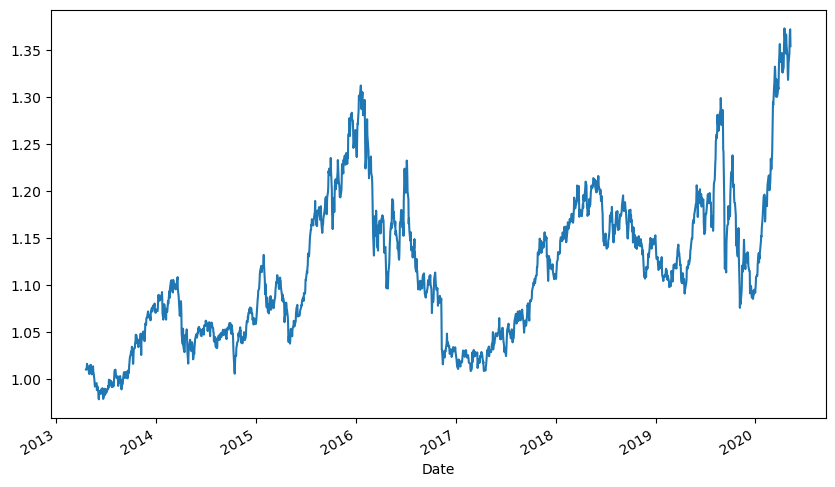

In [83]:
returns_df['djm cum returns'].plot(figsize=(10,6))

In [84]:
djt_month = djtmnmo_prices.pct_change().resample("M").agg(lambda x: (1+x).prod()-1)

In [85]:
djt_month = djt_month.reset_index()
djt_month.set_index("Date", inplace=True)
djt_month

,DJTMNMO
Date,
2013-04-30,0.006850
2013-05-31,-0.014740
2013-06-30,-0.008969
2013-07-31,0.017639
2013-08-31,-0.006507
...,...
2020-01-31,0.094293
2020-02-29,0.023910
2020-03-31,0.097717


In [86]:
df_WML_monthly = df_WML_monthly.merge(djt_month['DJTMNMO'],left_index=True, right_index=True, how='left')
df_WML_monthly['DJTMNMO Cum returns'] = (1+df_WML_monthly['DJTMNMO']).cumprod()

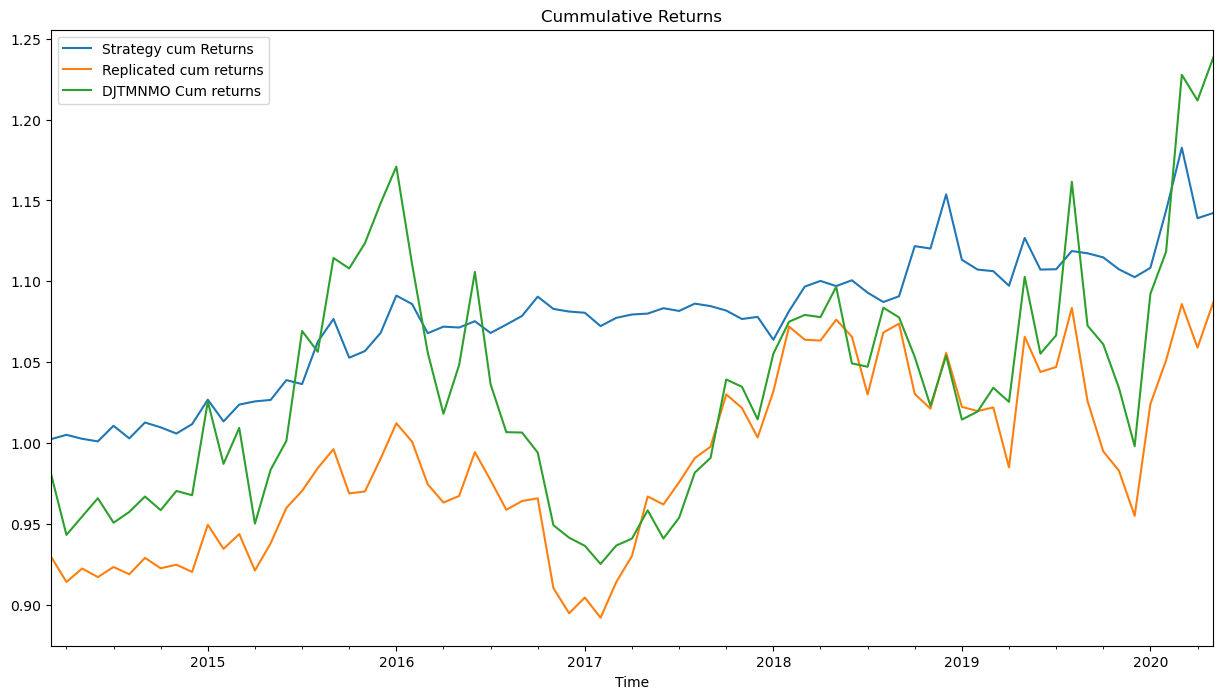

In [87]:
plt.figure(figsize=(15, 8))
df_WML_monthly['Strategy cum Returns'].plot(label = 'Strategy cum Returns')
df_WML_monthly['Replicated cum returns'].plot(label = 'Replicated cum returns')
df_WML_monthly['DJTMNMO Cum returns'].plot(label = 'DJTMNMO Cum returns')
plt.title('Cummulative Returns')
plt.xlabel('Time')
plt.legend()

Sharpe Ratio and Max Drawdown

In [88]:
risk_free_rate = df_WML_monthly['rf Close'].mean()

In [89]:
df_WML_monthly

,Replicated prices,SPY prices,Replicated returns,SPY returns,Replicated cum returns,SPY cum returns,12 mn cumulative_SPY_returns,Bull mkt ind,rf Close,Up mkt ind,Ib*Rmkt,Ib*Iut*Rmkt,Constant,Strategy returns,Strategy cum Returns,DJTMNMO,DJTMNMO Cum returns
Date,,,,,,,,,,,,,,,,,
2014-03-31,24176.826753,3311.677231,-0.040546,0.008665,0.930100,1.236817,0.219140,0,0.02723,1,0.000000,0.0,1,0.002387,1.002387,-0.018359,0.981641
2014-04-30,23337.739764,3317.028641,-0.017087,0.007603,0.914208,1.246221,0.191297,0,0.02648,1,0.000000,0.0,1,0.002741,1.005134,-0.039092,0.943267
2014-05-31,23257.254284,3368.083954,0.009051,0.023211,0.922482,1.275148,0.190697,0,0.02582,1,0.000000,0.0,1,-0.002465,1.002657,0.012045,0.954629
2014-06-30,23199.613877,3476.018982,-0.005737,0.020571,0.917190,1.301379,0.223558,0,0.02516,1,0.000000,0.0,1,-0.001584,1.001068,0.011848,0.965940
2014-07-31,24188.836443,3695.310211,0.006813,-0.013078,0.923439,1.284359,0.159831,0,0.02556,1,-0.000000,-0.0,1,0.009638,1.010717,-0.015657,0.950816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31,24852.768326,6520.841949,0.072346,0.000186,1.024114,2.411003,0.201402,0,0.01520,1,0.000000,0.0,1,0.005214,1.108317,0.094293,1.092225
2020-02-29,23437.494513,5906.987976,0.026427,-0.080032,1.051178,2.218045,0.089207,0,0.01109,1,-0.000000,-0.0,1,0.031966,1.143746,0.023910,1.118340
2020-03-31,29089.639882,5543.226593,0.033056,-0.099209,1.085925,1.997996,-0.028499,1,0.00698,0,-0.099209,-0.0,1,0.033942,1.182568,0.097717,1.227621


In [90]:
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_returns = returns - risk_free_rate
    average_return = np.mean(excess_returns)
    std_dev = np.std(returns)
    sharpe_ratio = average_return / std_dev
    return sharpe_ratio

def calculate_max_drawdown(returns):
    cumulative_returns = np.cumprod(1 + returns)
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = np.min(drawdown)
    return max_drawdown

# Monthly returns for Strategy 1 and Strategy 2
strategy_returns = df_WML_monthly['Strategy returns']
DJTMNMO_returns = df_WML_monthly['DJTMNMO']

# Risk-free rate (annualized)
risk_free_rate = risk_free_rate

# Calculate Sharpe ratio
sharpe_ratio_strategy = calculate_sharpe_ratio(strategy_returns, risk_free_rate)
sharpe_ratio_DJTMNMO = calculate_sharpe_ratio(DJTMNMO_returns, risk_free_rate)

# Calculate maximum drawdown
max_drawdown_strategy = calculate_max_drawdown(strategy_returns)
max_drawdown_DJTMNMO = calculate_max_drawdown(DJTMNMO_returns)

# Print the results
print("Sharpe Ratio - Strategy:", sharpe_ratio_strategy)
print("Sharpe Ratio - DJTMNMO:", sharpe_ratio_DJTMNMO)
print("Maximum Drawdown - Strategy:", max_drawdown_strategy)
print("Maximum Drawdown - DJTMNMO:", max_drawdown_DJTMNMO)


Sharpe Ratio - Strategy: -1.6249652481032335
Sharpe Ratio - DJTMNMO: -0.5275572723905338
Maximum Drawdown - Strategy: -0.04895073198966122
Maximum Drawdown - DJTMNMO: -0.20974491976245485


Reduced Maximum drawdown with the strategy, this takes care of the momentum crashes that happen during Bear market period.

## Momentum Traders Volume prediction

In [91]:
SPMO = yf.download("SPMO", start='2021-01-01', end='2022-12-31')

[*********************100%***********************]  1 of 1 completed


In [92]:
SPMO.drop(['Open', 'High', 'Low', 'Close'], axis = 1, inplace = True)
SPMO = SPMO.rename(columns = {'Volume': 'Momentum Volume', 'Adj Close': 'DJTMNMO Adj Close'})
SPMO

,DJTMNMO Adj Close,Momentum Volume
Date,,
2021-01-04,50.708794,6400
2021-01-05,51.115971,20500
2021-01-06,50.357018,10700
2021-01-07,51.348217,2800
2021-01-08,51.824390,79100
...,...,...
2022-12-23,56.436337,32200
2022-12-27,56.723431,36500
2022-12-28,55.908836,41100


In [93]:
#Market Sentiment Indicator
VIX = yf.download("^VIX", start='2021-01-01', end='2022-12-31')
VIX

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,23.040001,29.190001,22.559999,26.969999,26.969999,0
2021-01-05,26.940001,28.600000,24.799999,25.340000,25.340000,0
2021-01-06,25.480000,26.770000,22.139999,25.070000,25.070000,0
2021-01-07,23.670000,23.910000,22.250000,22.370001,22.370001,0
2021-01-08,22.430000,23.340000,21.420000,21.559999,21.559999,0
...,...,...,...,...,...,...
2022-12-23,22.170000,22.639999,20.780001,20.870001,20.870001,0
2022-12-27,21.670000,22.799999,21.590000,21.650000,21.650000,0
2022-12-28,21.469999,22.260000,20.959999,22.139999,22.139999,0


In [94]:
VIX.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
VIX = VIX.rename(columns = {'Close': 'VIX Close'})
VIX

,VIX Close
Date,
2021-01-04,26.969999
2021-01-05,25.340000
2021-01-06,25.070000
2021-01-07,22.370001
2021-01-08,21.559999
...,...
2022-12-23,20.870001
2022-12-27,21.650000
2022-12-28,22.139999


In [95]:
SPMO = SPMO.merge(VIX[['VIX Close']],left_index=True, right_index=True, how='left')
SPMO

,DJTMNMO Adj Close,Momentum Volume,VIX Close
Date,,,
2021-01-04,50.708794,6400,26.969999
2021-01-05,51.115971,20500,25.340000
2021-01-06,50.357018,10700,25.070000
2021-01-07,51.348217,2800,22.370001
2021-01-08,51.824390,79100,21.559999
...,...,...,...
2022-12-23,56.436337,32200,20.870001
2022-12-27,56.723431,36500,21.650000
2022-12-28,55.908836,41100,22.139999


In [96]:
SPY = yf.download("SPY", start='2021-01-01', end='2022-12-31')
SPY = SPY[["Adj Close", "Volume"]]
SPY = SPY.rename(columns = {'Adj Close': 'SPY mkt Close', 'Volume': 'SPY Mkt Volume'})
SPY


[*********************100%***********************]  1 of 1 completed


,SPY mkt Close,SPY Mkt Volume
Date,,
2021-01-04,356.767120,110210800
2021-01-05,359.224274,66426200
2021-01-06,361.371948,107997700
2021-01-07,366.740997,68766800
2021-01-08,368.830627,71677200
...,...,...
2022-12-23,381.454193,59857300
2022-12-27,379.949921,51638200
2022-12-28,375.227936,70911500


In [97]:
SPMO = SPMO.merge(SPY[['SPY mkt Close', 'SPY Mkt Volume']],left_index=True, right_index=True, how='left')
SPMO

,DJTMNMO Adj Close,Momentum Volume,VIX Close,SPY mkt Close,SPY Mkt Volume
Date,,,,,
2021-01-04,50.708794,6400,26.969999,356.767120,110210800
2021-01-05,51.115971,20500,25.340000,359.224274,66426200
2021-01-06,50.357018,10700,25.070000,361.371948,107997700
2021-01-07,51.348217,2800,22.370001,366.740997,68766800
2021-01-08,51.824390,79100,21.559999,368.830627,71677200
...,...,...,...,...,...
2022-12-23,56.436337,32200,20.870001,381.454193,59857300
2022-12-27,56.723431,36500,21.650000,379.949921,51638200
2022-12-28,55.908836,41100,22.139999,375.227936,70911500


In [98]:
#Long only momemtum index
MTUM = yf.download("MTUM", start='2021-01-01', end='2022-12-31')
MTUM = MTUM[["Adj Close", "Volume"]]
MTUM = MTUM.rename(columns = {'Adj Close': 'MTUM mkt Close', 'Volume': 'MTUM Mkt Volume'})
MTUM

[*********************100%***********************]  1 of 1 completed


,MTUM mkt Close,MTUM Mkt Volume
Date,,
2021-01-04,155.380463,1049100
2021-01-05,156.787979,811800
2021-01-06,155.574631,1130400
2021-01-07,160.389267,788900
2021-01-08,163.039322,1287000
...,...,...
2022-12-23,145.756866,436600
2022-12-27,146.015320,329100
2022-12-28,144.295624,302500


In [99]:
SPMO = SPMO.merge(MTUM[['MTUM mkt Close', 'MTUM Mkt Volume']],left_index=True, right_index=True, how='left')
SPMO

,DJTMNMO Adj Close,Momentum Volume,VIX Close,SPY mkt Close,SPY Mkt Volume,MTUM mkt Close,MTUM Mkt Volume
Date,,,,,,,
2021-01-04,50.708794,6400,26.969999,356.767120,110210800,155.380463,1049100
2021-01-05,51.115971,20500,25.340000,359.224274,66426200,156.787979,811800
2021-01-06,50.357018,10700,25.070000,361.371948,107997700,155.574631,1130400
2021-01-07,51.348217,2800,22.370001,366.740997,68766800,160.389267,788900
2021-01-08,51.824390,79100,21.559999,368.830627,71677200,163.039322,1287000
...,...,...,...,...,...,...,...
2022-12-23,56.436337,32200,20.870001,381.454193,59857300,145.756866,436600
2022-12-27,56.723431,36500,21.650000,379.949921,51638200,146.015320,329100
2022-12-28,55.908836,41100,22.139999,375.227936,70911500,144.295624,302500


In [100]:
SPMO['SPY Mkt Returns'] = SPMO['SPY mkt Close'].pct_change()
SPMO['VIX Returns'] = SPMO['VIX Close'].pct_change()
SPMO['MTUM Returns'] = SPMO['MTUM mkt Close'].pct_change()
SPMO.dropna(inplace = True)
SPMO

,DJTMNMO Adj Close,Momentum Volume,VIX Close,SPY mkt Close,SPY Mkt Volume,MTUM mkt Close,MTUM Mkt Volume,SPY Mkt Returns,VIX Returns,MTUM Returns
Date,,,,,,,,,,
2021-01-05,51.115971,20500,25.340000,359.224274,66426200,156.787979,811800,0.006887,-0.060437,0.009059
2021-01-06,50.357018,10700,25.070000,361.371948,107997700,155.574631,1130400,0.005979,-0.010655,-0.007739
2021-01-07,51.348217,2800,22.370001,366.740997,68766800,160.389267,788900,0.014857,-0.107698,0.030947
2021-01-08,51.824390,79100,21.559999,368.830627,71677200,163.039322,1287000,0.005698,-0.036209,0.016523
2021-01-11,51.482323,6000,24.080000,366.344391,51034700,161.039673,982700,-0.006741,0.116883,-0.012265
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,56.436337,32200,20.870001,381.454193,59857300,145.756866,436600,0.005752,-0.050068,0.010893
2022-12-27,56.723431,36500,21.650000,379.949921,51638200,146.015320,329100,-0.003944,0.037374,0.001773
2022-12-28,55.908836,41100,22.139999,375.227936,70911500,144.295624,302500,-0.012428,0.022633,-0.011778


In [101]:
SPMO.columns

Index(['DJTMNMO Adj Close', 'Momentum Volume', 'VIX Close', 'SPY mkt Close',
       'SPY Mkt Volume', 'MTUM mkt Close', 'MTUM Mkt Volume',
       'SPY Mkt Returns', 'VIX Returns', 'MTUM Returns'],
      dtype='object')

### Model

In [103]:
SPMO.describe()

,DJTMNMO Adj Close,Momentum Volume,VIX Close,SPY mkt Close,SPY Mkt Volume,MTUM mkt Close,MTUM Mkt Volume,SPY Mkt Returns,VIX Returns,MTUM Returns
count,502.000000,502.00000,502.000000,502.000000,5.020000e+02,502.000000,5.020000e+02,502.000000,502.000000,502.000000
mean,56.423687,27495.01992,22.625578,409.116499,8.420488e+07,157.921510,1.146368e+06,0.000206,0.002792,-0.000031
std,3.909493,57741.08286,4.933094,28.816504,3.190695e+07,15.341185,9.839978e+05,0.012259,0.083627,0.014549
min,48.347401,900.00000,15.010000,353.580688,3.054540e+07,127.757828,1.154000e+05,-0.043483,-0.197764,-0.047869
25%,53.165678,4525.00000,18.587500,383.786385,5.973715e+07,144.203709,5.989250e+05,-0.006749,-0.045091,-0.008114
50%,56.069448,10300.00000,21.865000,407.625946,7.749270e+07,160.293091,8.387000e+05,0.000318,-0.012016,0.000310
75%,59.623554,26175.00000,26.030000,432.228119,1.029828e+08,169.986713,1.309175e+06,0.007604,0.041313,0.008479
max,63.968235,594100.00000,37.209999,468.296417,2.517839e+08,188.668625,8.255000e+06,0.054954,0.616420,0.050000


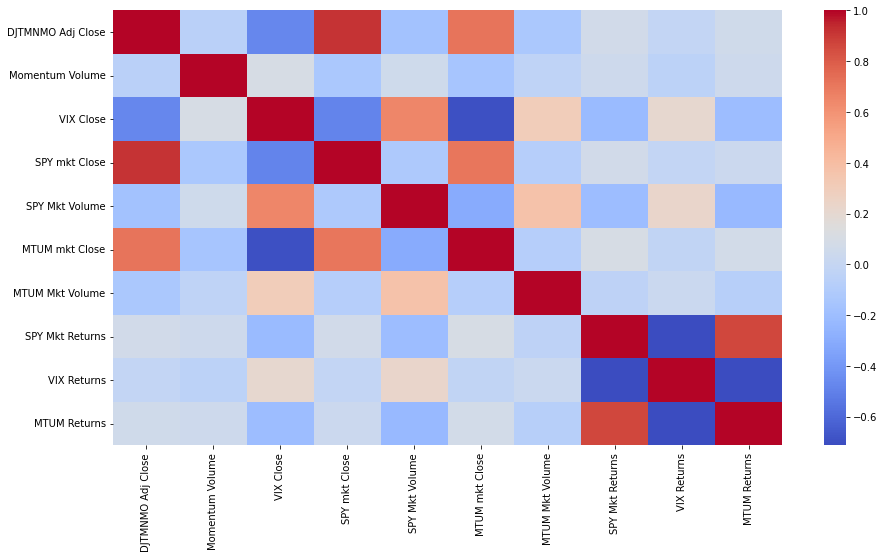

In [104]:
correlated_matrix = SPMO.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(correlated_matrix, cmap='coolwarm')
plt.show()

In [105]:
def train_test_split(df):
  tss = TimeSeriesSplit(n_splits = 5)
  X = df.drop(labels = ['Momentum Volume'], axis = 1)
  y = df['Momentum Volume']
  for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  return X_train, y_train, X_test, y_test

def Normalization(df):
  window_size = 30

  # Create a scaler object
  scaler = StandardScaler()

  # Iterate through the time series data and apply window scaling
  for i in range(df.shape[0]):
      # Determine the start and end of the window
      start_index = max(0, i - window_size)
      end_index = min(i + 1, df.shape[0])
      
      # Extract the window of data
      window = df[start_index:end_index]
      
      # Fit the scaler to the window of data
      scaler.fit(window)
      
      # Transform the current observation using the scaler
      current_observation = df[i:i+1]
      scaled_observation = scaler.transform(current_observation)
      
      # Update the dataframe with the scaled observation
      df[i:i+1] = scaled_observation
  return df, scaler

In [106]:
def Normalization_Split_train(df):
#   data_preprocessed = Preprocess(df, df1)
  X_train_processed, y_train_processed, X_validate_processed, y_validate_processed = train_test_split(df)
 
  #scaler = StandardScaler()
 
  X_train_processed, scaler_xtrain = Normalization(X_train_processed.to_numpy())
  y_train_processed, scaler_ytrain = Normalization(y_train_processed.to_numpy().reshape(-1,1))
  
  X_validate_processed, scaler_xval = Normalization(X_validate_processed.to_numpy())
  y_validate_processed, scaler_yval = Normalization(y_validate_processed.to_numpy().reshape(-1,1))
  return X_train_processed, y_train_processed, X_validate_processed, y_validate_processed, scaler_xtrain, scaler_ytrain, scaler_xval, scaler_yval

In [107]:
def plot(y_validate_processed, predicted_volume):
  plt.figure(figsize=(15, 10))
  plt.plot(y_validate_processed, color = 'red', label = 'Actual Volume')
  plt.plot(predicted_volume, color = 'blue', label = 'Predicted Volume')
  plt.title('Momentum Volume Prediction')
  plt.xlabel('Time')
  plt.ylabel('Volume')
  plt.legend()

In [108]:
X_train_processed, y_train_processed, X_validate_processed, y_validate_processed, scaler_xtrain, scaler_ytrain, scaler_xval, scaler_yval = Normalization_Split_train(SPMO)

/var/folders/x9/86sjrd415rz_4n_jdwxv29b40000gn/T/ipykernel_54584/4269944872.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X, y)


DJTMNMO Adj Close: 0.1833
VIX Close: 0.1907
SPY mkt Close: 0.1662
SPY Mkt Volume: 0.1456
MTUM mkt Close: 0.1640
MTUM Mkt Volume: 0.1487
SPY Mkt Returns: 0.0004
VIX Returns: 0.0009
MTUM Returns: 0.0002


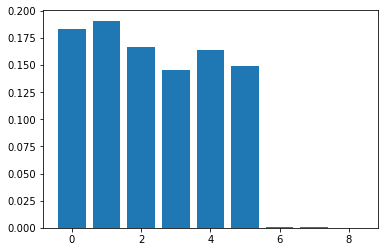

In [109]:
#Feature Importance
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# define dataset
X, y = X_train_processed, y_train_processed
model = RandomForestRegressor()
model.fit(X, y)
# get importance
importances = model.feature_importances_
feature_names = SPMO.drop(labels=['Momentum Volume'], axis=1).columns
for name, importance in zip(feature_names, importances):
    print(f'{name}: {importance:.4f}')
# plot feature importance
pyplot.bar([x for x in range(len(importances))], importances)
pyplot.show()

### ANN Model

In [110]:
model1 = None
model1 = tf.keras.Sequential()
units = 50

model1.add(Dense(units = units,kernel_regularizer=l2(0.01), input_shape = (X_train_processed.shape[1], 1), name = 'Dense_head', activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units = units, name = 'Dense_1', activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units = units, name = 'Dense_2', activation = 'relu'))
model1.add(Dropout(0.2))
# model1.add(Dense(units = units, name = 'Dense_3', activation = 'relu'))
# model1.add(Dropout(0.2))
model1.add(Dense(units=1, activation = 'linear', name = 'Output_layer'))
model1.add(Flatten())
model1.add(Dense(units=1, activation='linear', name='Final_output'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_head (Dense)          (None, 9, 50)             100       
                                                                 
 dropout (Dropout)           (None, 9, 50)             0         
                                                                 
 Dense_1 (Dense)             (None, 9, 50)             2550      
                                                                 
 dropout_1 (Dropout)         (None, 9, 50)             0         
                                                                 
 Dense_2 (Dense)             (None, 9, 50)             2550      
                                                                 
 dropout_2 (Dropout)         (None, 9, 50)             0         
                                                                 
 Output_layer (Dense)        (None, 9, 1)              5

2023-05-15 20:18:46.837324: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
14/14 [==============================] - 1s 21ms/step - loss: 24.1817 - mean_squared_error: 24.1590 - val_loss: 6.6934 - val_mean_squared_error: 6.6705
Epoch 2/200
14/14 [==============================] - 0s 4ms/step - loss: 4.3020 - mean_squared_error: 4.2788 - val_loss: 0.3552 - val_mean_squared_error: 0.3315
Epoch 3/200
14/14 [==============================] - 0s 4ms/step - loss: 1.6565 - mean_squared_error: 1.6328 - val_loss: 0.2244 - val_mean_squared_error: 0.2011
Epoch 4/200
14/14 [==============================] - 0s 4ms/step - loss: 1.1956 - mean_squared_error: 1.1725 - val_loss: 0.3262 - val_mean_squared_error: 0.3034
Epoch 5/200
14/14 [==============================] - 0s 4ms/step - loss: 1.0199 - mean_squared_error: 0.9971 - val_loss: 0.2166 - val_mean_squared_error: 0.1939
Epoch 6/200
14/14 [==============================] - 0s 4ms/step - loss: 0.8788 - mean_squared_error: 0.8562 - val_loss: 0.2716 - val_mean_squared_error: 0.2492
Epoch 7/200
14/14 [============

14/14 [==============================] - 0s 3ms/step - loss: 0.1934 - mean_squared_error: 0.1820 - val_loss: 0.8209 - val_mean_squared_error: 0.8096
Epoch 102/200
14/14 [==============================] - 0s 3ms/step - loss: 0.1600 - mean_squared_error: 0.1487 - val_loss: 0.9317 - val_mean_squared_error: 0.9204
Epoch 103/200
14/14 [==============================] - 0s 4ms/step - loss: 0.1695 - mean_squared_error: 0.1583 - val_loss: 0.8712 - val_mean_squared_error: 0.8599
Epoch 104/200
14/14 [==============================] - 0s 4ms/step - loss: 0.1690 - mean_squared_error: 0.1577 - val_loss: 0.9528 - val_mean_squared_error: 0.9416
Epoch 105/200
14/14 [==============================] - 0s 3ms/step - loss: 0.1718 - mean_squared_error: 0.1606 - val_loss: 0.9647 - val_mean_squared_error: 0.9536
Epoch 106/200
14/14 [==============================] - 0s 3ms/step - loss: 0.1483 - mean_squared_error: 0.1372 - val_loss: 1.2335 - val_mean_squared_error: 1.2224
Epoch 107/200
14/14 [===============

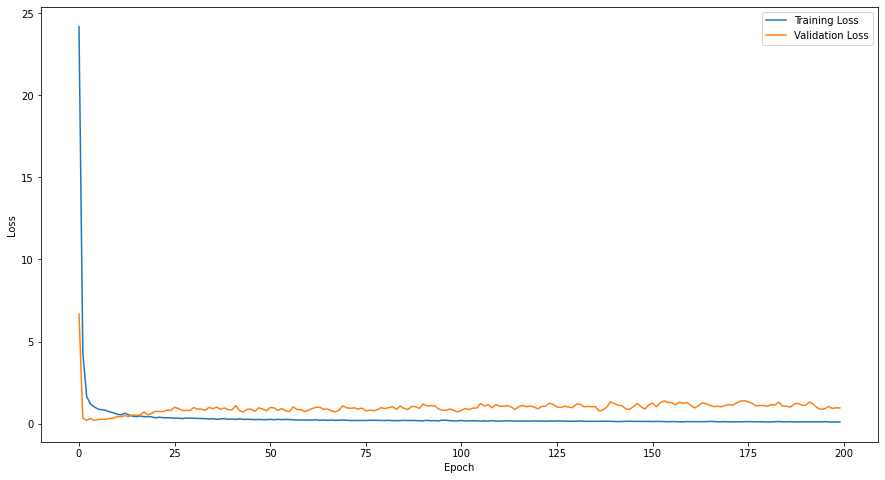

In [111]:
model_name1 = "ANN"
loss = "mean_squared_error"
optimizer = "adam"
model1.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[loss])
history1 = model1.fit(X_train_processed, y_train_processed, validation_data=(X_validate_processed, y_validate_processed), epochs=200, batch_size=32, verbose = 1)
plt.figure(figsize=(15,8))
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_mean_squared_error'], label='Validation Loss')
# Plot loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [112]:
predicted_volume_train = model1.predict(X_train_processed)
predicted_volume_val = model1.predict(X_validate_processed)

3/3 [==============================] - 0s 2ms/step


In [113]:
y_train_processed_ANN = scaler_ytrain.inverse_transform(y_train_processed)
y_validate_processed_ANN = scaler_yval.inverse_transform(y_validate_processed)
predicted_volume_ANN_train = scaler_ytrain.inverse_transform(predicted_volume_train)
predicted_volume_ANN_val = scaler_yval.inverse_transform(predicted_volume_val)

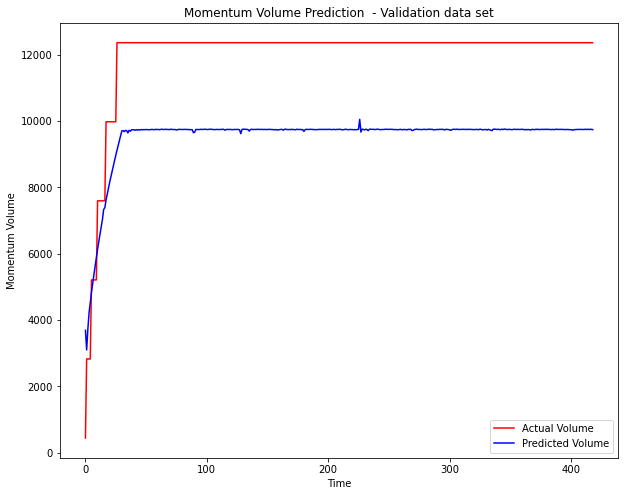

In [114]:
#Train
plt.figure(figsize=(10, 8))
plt.plot(y_train_processed_ANN, color = 'red', label = 'Actual Volume')
plt.plot(predicted_volume_ANN_train, color = 'blue', label = 'Predicted Volume')
plt.title('Momentum Volume Prediction  - Validation data set')
plt.xlabel('Time')
plt.ylabel('Momentum Volume')
plt.legend()

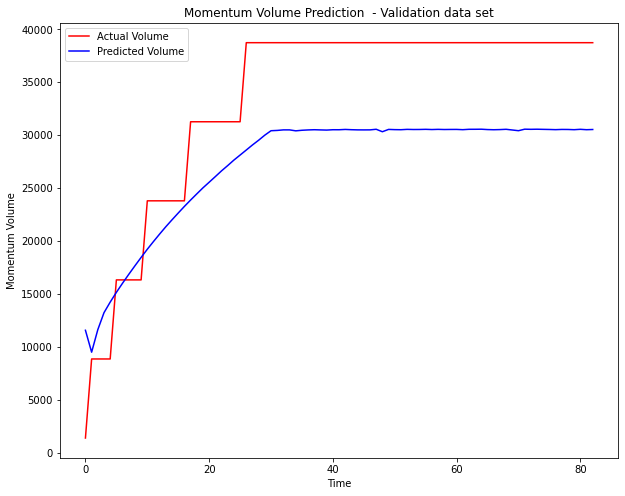

In [115]:
#Validation
plt.figure(figsize=(10, 8))
plt.plot(y_validate_processed_ANN, color = 'red', label = 'Actual Volume')
plt.plot(predicted_volume_ANN_val, color = 'blue', label = 'Predicted Volume')
plt.title('Momentum Volume Prediction  - Validation data set')
plt.xlabel('Time')
plt.ylabel('Momentum Volume')
plt.legend()

In [116]:
mse = mean_squared_error(y_validate_processed_ANN, predicted_volume_ANN_val)
mae = mean_absolute_error(y_validate_processed_ANN, predicted_volume_ANN_val)
rmse = np.sqrt(mse)
r2 = r2_score(y_validate_processed_ANN, predicted_volume_ANN_val)
mape = mean_absolute_percentage_error(y_validate_processed_ANN, predicted_volume_ANN_val)

print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R2) score:', r2)
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Squared Error (MSE): 53348922.7517305
Root Mean Squared Error (RMSE): 7304.034689932031
Mean Absolute Error (MAE): 6829.252333831512
R-squared (R2) score: 0.3856224334136169
Mean Absolute Percentage Error (MAPE): 0.28582027227145923


In [117]:
print("Done!")

Done!
